## Decision Tree

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [73]:
import os

DATA_DIR = './data'
DATA_FILE = 'churn_data_encoded.csv'

data_path = os.path.join(DATA_DIR, DATA_FILE)
data = pd.read_csv(data_path, sep=',')
print(data.head())

   Churn  Gender  Age  Under 30  Senior Citizen  Married  Dependents  \
0      0       0   36         0               0        1           0   
1      0       1   46         0               0        0           0   
2      1       1   37         0               0        0           0   
3      0       1   53         0               0        0           0   
4      1       0   19         1               0        0           1   

   Number of Dependents  Zip Code   Latitude  ...  Offer_Offer E  \
0                     0     90001  33.973616  ...           True   
1                     0     90002  33.949255  ...          False   
2                     0     90003  33.964131  ...          False   
3                     0     90004  34.076259  ...          False   
4                     2     90005  34.059281  ...          False   

   Internet Type_Cable  Internet Type_DSL  Internet Type_Fiber Optic  \
0                False               True                      False   
1             

In [75]:
data[data['Churn'] == 1]

,Churn,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Zip Code,Latitude,...,Offer_Offer E,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Payment Method_Bank Withdrawal,Payment Method_Credit Card,Payment Method_Mailed Check
2,1,1,37,0,0,0,0,0,90003,33.964131,...,False,False,True,False,True,False,False,False,True,False
4,1,0,19,1,0,0,1,2,90005,34.059281,...,False,False,False,True,True,False,False,True,False,False
5,1,0,31,0,0,0,1,2,90006,34.048013,...,False,True,False,False,True,False,False,True,False,False
8,1,0,23,1,0,1,1,3,90010,34.062125,...,False,False,False,True,True,False,False,True,False,False
13,1,1,38,0,0,0,1,1,90015,34.039224,...,False,False,False,True,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7021,1,1,44,0,0,0,0,0,92264,33.745746,...,False,True,False,False,False,True,False,True,False,False
7026,1,0,40,0,0,0,0,0,92273,32.790282,...,False,True,False,False,True,False,False,True,False,False
7032,1,1,79,0,1,0,0,0,92027,33.141265,...,False,False,False,True,True,False,False,True,False,False
7034,1,0,28,1,0,0,0,0,92282,33.972293,...,False,False,False,True,True,False,False,False,True,False


Matplotlib is building the font cache; this may take a moment.


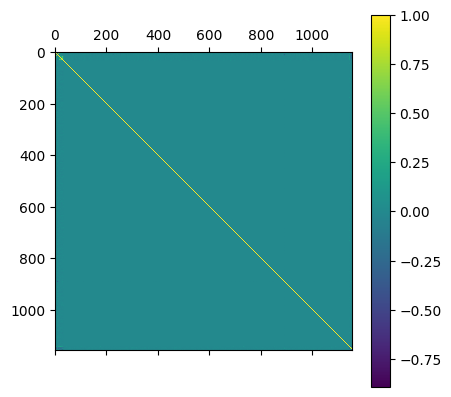

In [60]:
import matplotlib.pyplot as plt

# Exclude non-numeric columns from correlation calculation
# numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = data.corr()

# Visualize the correlations
plt.matshow(correlation_matrix)
plt.colorbar()

plt.show()

### Highest Correlation

In [62]:
# Retain upper triangular values of correlation matrix and 
# make Lower triangular values Null 
upper_corr_mat = correlation_matrix.where( 
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))   
  
# Convert to 1-D series and drop Null values 
unique_corr_pairs = upper_corr_mat.unstack().dropna() 

# Sort correlation pairs 
sorted_mat = unique_corr_pairs.sort_values() 
print(sorted_mat)

Payment Method_Credit Card  Payment Method_Bank Withdrawal   -0.893593
Longitude                   Latitude                         -0.885979
                            Zip Code                         -0.790564
Satisfaction Score          Churn                            -0.754649
Under 30                    Age                              -0.672651
                                                                ...   
Total Revenue               Tenure in Months                  0.853146
Number of Dependents        Dependents                        0.888234
Latitude                    Zip Code                          0.894769
Referred a Friend           Married                           0.949987
Total Revenue               Total Charges                     0.972212
Length: 667590, dtype: float64


## Classification

In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Features und Zielvariable trennen
X = data.drop(columns=['Churn'])
y = data['Churn']

# Überprüfen der Klassenverteilung
print(y.value_counts())

def evaluate_classification(X, y):
    clf = DecisionTreeClassifier()
    cv = StratifiedKFold(n_splits=10)
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'f1': make_scorer(f1_score, zero_division=0)
    }
    scores = cross_validate(clf, X, y, cv=cv, scoring=scoring)
    return scores

def print_scores_and_statistics(scores):
    scores_df = pd.DataFrame({
        'Fold': np.arange(1, len(scores['test_accuracy']) + 1),
        'Accuracy': scores['test_accuracy'],
        'Precision': scores['test_precision'],
        'Recall': scores['test_recall'],
        'F1 Score': scores['test_f1']
    })
    print("Scores:\n", scores_df)

    metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
    statistics = pd.DataFrame(index=metrics, columns=['Min', 'Median', 'Max'])

    for metric in metrics:
        statistics.loc[metric, 'Min'] = np.min(scores[metric])
        statistics.loc[metric, 'Median'] = np.median(scores[metric])
        statistics.loc[metric, 'Max'] = np.max(scores[metric])
        
    print("\nStatistics:\n", statistics)

scores = evaluate_classification(X, y)
print_scores_and_statistics(scores)

Churn
0    5174
1    1869
Name: count, dtype: int64
Scores:
    Fold  Accuracy  Precision    Recall  F1 Score
0     1  0.920567   0.842932  0.860963  0.851852
1     2  0.960284   0.944134  0.903743  0.923497
2     3  0.957447   0.928962  0.909091  0.918919
3     4  0.960227   0.929348  0.919355  0.924324
4     5  0.936080   0.877660  0.882353  0.880000
5     6  0.957386   0.943503  0.893048  0.917582
6     7  0.964489   0.950000  0.914439  0.931880
7     8  0.953125   0.918478  0.903743  0.911051
8     9  0.941761   0.888298  0.893048  0.890667
9    10  0.960227   0.939227  0.909091  0.923913

Statistics:
                      Min    Median       Max
test_accuracy   0.920567  0.957417  0.964489
test_precision  0.842932  0.929155      0.95
test_recall     0.860963  0.903743  0.919355
test_f1         0.851852  0.918251   0.93188


## Optimisation (Bagging and Boosting)

In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Evaluierung des Klassifikationsmodells
def evaluate_classification_optimising(model, X, y):
    # Definiere die 10-fache Kreuzvalidierung
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # Metriken
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'f1': make_scorer(f1_score, zero_division=0)
    }
    
    # Kreuzvalidierung 
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    
    print(f"Accuracy: {scores['test_accuracy'].mean():.4f}")
    print(f"Precision: {scores['test_precision'].mean():.4f}")
    print(f"Recall: {scores['test_recall'].mean():.4f}")
    print(f"F1-Score: {scores['test_f1'].mean():.4f}")
    
    return scores

# Definieren Sie das Parametergitter für RandomForestClassifier
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Grid Search für RandomForestClassifier
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_param_grid, cv=5)
rf_grid_search.fit(X, y)

# Beste Parameter für RandomForestClassifier
print("Best parameters for RandomForestClassifier:", rf_grid_search.best_params_)

# Evaluieren des besten RandomForestClassifiers
rf_best_model = rf_grid_search.best_estimator_
rf_scores = evaluate_classification_optimising(rf_best_model, X, y)
print("RandomForestClassifier Results:")
print_scores_and_statistics(rf_scores)

# Definieren Sie das Parametergitter für AdaBoostClassifier
ab_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [1, 2, 3]
}

# Grid Search für AdaBoostClassifier
ab_grid_search = GridSearchCV(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(), algorithm='SAMME'), param_grid=ab_param_grid, cv=5)
ab_grid_search.fit(X, y)

# Beste Parameter für AdaBoostClassifier
print("Best parameters for AdaBoostClassifier:", ab_grid_search.best_params_)

# Evaluieren des besten AdaBoostClassifiers
ab_best_model = ab_grid_search.best_estimator_
ab_scores = evaluate_classification_optimising(ab_best_model, X, y)
print("AdaBoostClassifier Results:")
print_scores_and_statistics(ab_scores)

Best parameters for RandomForestClassifier: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.9523
Precision: 0.9636
Recall: 0.8523
F1-Score: 0.9044
RandomForestClassifier Results:
Scores:
    Fold  Accuracy  Precision    Recall  F1 Score
0     1  0.954610   0.953216  0.871658  0.910615
1     2  0.964539   0.970930  0.893048  0.930362
2     3  0.963121   0.976331  0.882353  0.926966
3     4  0.943182   0.956250  0.822581  0.884393
4     5  0.955966   0.975610  0.855615  0.911681
5     6  0.954545   0.969697  0.855615  0.909091
6     7  0.926136   0.919255  0.791444  0.850575
7     8  0.950284   0.975000  0.834225  0.899135
8     9  0.951705   0.958084  0.855615  0.903955
9    10  0.958807   0.981707  0.860963  0.917379

Statistics:
                      Min    Median       Max
test_accuracy   0.926136  0.954578  0.964539
test_precision  0.919255  0.970314  0.981707
test_recall     0.791444  0.855615  0.893048
test_f1         0.850575  0.909853  0.930362
Best pa

## Feature Importance

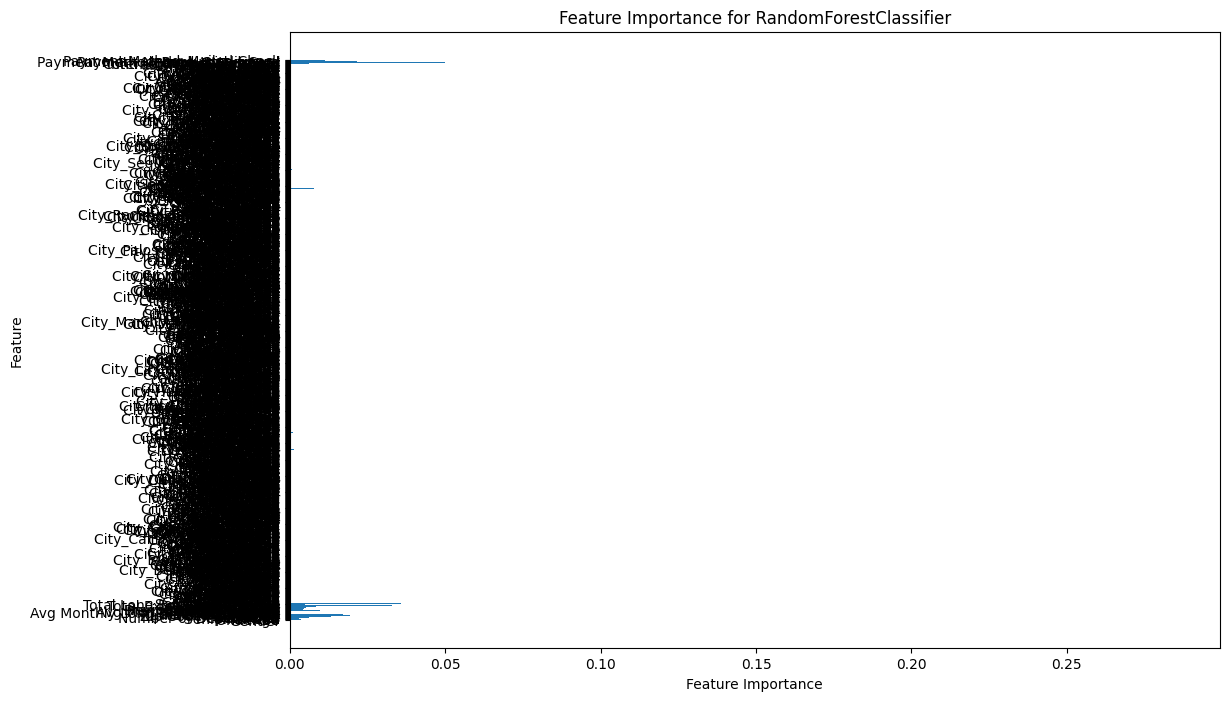

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [86]:
import matplotlib.pyplot as plt

# Feature Importance für RandomForestClassifier
rf_importances = rf_best_model.feature_importances_
rf_features = X.columns

plt.figure(figsize=(12, 8))
plt.barh(rf_features, rf_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for RandomForestClassifier")
plt.show()

# Feature Importance für AdaBoostClassifier
ab_importances = ab_best_model.estimator_.feature_importances_
ab_features = X.columns

plt.figure(figsize=(12, 8))
plt.barh(ab_features, ab_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for AdaBoostClassifier")
plt.show()


In [ ]:
# Definieren Sie das Parametergitter für AdaBoostClassifier
ab_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [1, 2, 3]
}

# Grid Search für AdaBoostClassifier
ab_grid_search = GridSearchCV(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier()), param_grid=ab_param_grid, cv=5)
ab_grid_search.fit(X, y)

# Beste Parameter für AdaBoostClassifier
print("Best parameters for AdaBoostClassifier:", ab_grid_search.best_params_)

# Evaluieren des besten AdaBoostClassifiers
ab_best_model = ab_grid_search.best_estimator_
ab_scores = evaluate_classification_optimising(ab_best_model, X, y)
print("AdaBoostClassifier Results:")
print_scores_and_statistics(ab_scores)

In [58]:
import pandas as pd
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold

# Daten laden
DATA_DIR = './data'
DATA_FILE = 'churn_data_encoded.csv'
data_path = os.path.join(DATA_DIR, DATA_FILE)
data = pd.read_csv(data_path, sep=',')

# Features
X = data.drop(columns=['Churn'])
y = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Evaluierung des Klassifikationsmodells
def evaluate_classification(X, y, pipeline):
    # Definiere die 10-fache Kreuzvalidierung
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # Metriken
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'f1': make_scorer(f1_score, zero_division=0)
    }
    
    # Kreuzvalidierung 
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_train_score=False)
    
    print(f"Accuracy: {scores['test_accuracy'].mean():.4f}")
    print(f"Precision: {scores['test_precision'].mean():.4f}")
    print(f"Recall: {scores['test_recall'].mean():.4f}")
    print(f"F1-Score: {scores['test_f1'].mean():.4f}")

# Funktion zur Evaluierung des Random Forest Modells
def train_evaluate_random_forest(X, y):
    pipeline = Pipeline([
        ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
    ])
    evaluate_classification(X, y, pipeline)

# Funktion zur Evaluierung des AdaBoost Modells
def train_evaluate_adaboost(X, y):
    pipeline = Pipeline([
        ('classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                          n_estimators=50, learning_rate=1.0, random_state=42))
    ])
    evaluate_classification(X, y, pipeline)

# Random Forest Modell evaluieren
print("Random Forest:")
train_evaluate_random_forest(X, y)

# AdaBoost Modell evaluieren
print("\nAdaBoost:")
train_evaluate_adaboost(X, y)

Random Forest:
Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000

AdaBoost:


TypeError: __init__() got an unexpected keyword argument 'base_estimator'

In [10]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np


def preprocessing_and_evaluate(df):
    # Auswahl der Features und des Ziels
    drop_columns = ['Customer ID', 'Total Revenue', 'Total Charges', 'Total Long Distance Charges']
    X = df.drop(columns=['Churn'] + drop_columns)
    y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Imputation fehlender Werte und OneHotEncoding
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Pipeline mit Vorverarbeitung, SMOTE und Klassifikation
    classifier_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])

    # Kreuzvalidierung und Bewertung
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'f1': make_scorer(f1_score, zero_division=0)
    }
    scores = cross_validate(classifier_pipeline, X, y, cv=cv, scoring=scoring, return_train_score=False)
    
    return scores

# Rufe die Funktion auf 
results = preprocessing_and_evaluate(data)
print("Accuracy: {:.4f}".format(np.mean(results['test_accuracy'])))
print("Precision: {:.4f}".format(np.mean(results['test_precision'])))
print("Recall: {:.4f}".format(np.mean(results['test_recall'])))
print("F1-Score: {:.4f}".format(np.mean(results['test_f1'])))

Accuracy: 0.9561
Precision: 0.9275
Recall: 0.9058
F1-Score: 0.9163


## Random Forest (Bagging) and AdaBoost (Boosting)

### Prepare Data

In [39]:
import pandas as pd
import numpy as np
import os 
from imblearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

DATA_DIR = './data' 
DATA_FILE = 'churn_data.csv' 
data_path = os.path.join(DATA_DIR, DATA_FILE)

# Lade die Daten
data = pd.read_csv(data_path)

def prepare_data(df):
    drop_columns = ['Customer ID', 'Total Revenue', 'Total Charges', 'Total Long Distance Charges']
    existing_drop_columns = [col for col in drop_columns if col in df.columns]
    X = df.drop(columns=['Churn'] + existing_drop_columns)
    y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
    
    # Definiere numerische und kategoriale Features
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean'))
    ])
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    return X, y, preprocessor


In [40]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

def train_evaluate_random_forest(data):
    # Bereite die Daten vor
    X, y, preprocessor = prepare_data(data)

    # Pipeline konfigurieren
    classifier_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
    ])

    # Kreuzvalidierung und Modellbewertung
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scoring = {
        'accuracy': make_scorer(accuracy_score), 
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0), 
        'f1': make_scorer(f1_score, zero_division=0)
    }
    results = cross_validate(classifier_pipeline, X, y, cv=cv, scoring=scoring)
    
    return results



In [46]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier

def train_evaluate_adaboost(data):
    # Bereite die Daten vor
    X, y, preprocessor = prepare_data(data)

    # Pipeline konfigurieren
    classifier_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                          n_estimators=50, learning_rate=1.0, random_state=42))
    ])

    # Kreuzvalidierung und Modellbewertung
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scoring = {
        'accuracy': make_scorer(accuracy_score), 
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0), 
        'f1': make_scorer(f1_score, zero_division=0)
    }
    results = cross_validate(classifier_pipeline, X, y, cv=cv, scoring=scoring)
    
    return results

In [47]:
import numpy as np
# Random Forest Modell evaluieren
rf_results = train_evaluate_random_forest(data)
print("Random Forest:")
print("Accuracy: {:.4f}".format(np.mean(rf_results['test_accuracy'])))
print("Precision: {:.4f}".format(np.mean(rf_results['test_precision'])))
print("Recall: {:.4f}".format(np.mean(rf_results['test_recall'])))
print("F1-Score: {:.4f}".format(np.mean(rf_results['test_f1'])))

# AdaBoost Modell evaluieren
ab_results = train_evaluate_adaboost(data)
print("\nAdaBoost:")
print("Accuracy: {:.4f}".format(np.mean(ab_results['test_accuracy'])))
print("Precision: {:.4f}".format(np.mean(ab_results['test_precision'])))
print("Recall: {:.4f}".format(np.mean(ab_results['test_recall'])))
print("F1-Score: {:.4f}".format(np.mean(ab_results['test_f1'])))

Random Forest:
Accuracy: 0.9191
Precision: 0.9251
Recall: 0.7565
F1-Score: 0.8318


TypeError: __init__() got an unexpected keyword argument 'base_estimator'